Mounting Drive to access data

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
  from google.colab import drive
  drive.mount('/content/drive' , force_remount = True)
  filtered_merged = "/content/drive/MyDrive/B_Tech_ECE/Own Final Year Project/combined_annotated.csv"
  AE_features = "/content/drive/MyDrive/B_Tech_ECE/Own Final Year Project/AE_features.csv"
  encoder_save = "/content/drive/MyDrive/B_Tech_ECE/Own Final Year Project/encoder_model.keras"
  decoder_save = "/content/drive/MyDrive/B_Tech_ECE/Own Final Year Project/decoder_model.keras"
else:
  from imported_files.paths_n_vars import filtered_merged ,AE_features, encoder_save, decoder_save

#### Import TensorFlow and other libraries


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%pip install tensorflow --quiet
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

from sklearn.model_selection import train_test_split

from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import TensorBoard

Note: you may need to restart the kernel to use updated packages.

Num GPUs Available:  0


Parameters

In [3]:
rand_state = 54
test_fraction = 0.3

latent_dim = 100
activation_func = 'ReLU'
activation_func_latent_dim = 'tanh'

activation_func_dec_out = 'selu'
optimizer = 'adam'
num_epochs = 300
batch_size = 5

User defined functions

In [4]:
def plot_signal(x : list|range ,y : list , x_label = "" , y_label = "" , title = ""):
    plt.grid(True)
    plt.plot(x,y)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.show()
    plt.close()

def MyMinMaxScaler(dataframe : pd.DataFrame):
    '''
    Scales each PPG segment individually
    Function assumes the PPG segments are present column wise in the given DataFrame
    '''
    return (dataframe - dataframe.min())/(dataframe.max() - dataframe.min())

def MyZScoreScaler(dataframe : pd.DataFrame):
    '''
    Scales each PPG segment individually
    Function assumes the PPG segments are present column wise in the given DataFrame
    '''
    return (dataframe - dataframe.mean())/(dataframe.std())

#### Load the dataset

scaled_data shape = (3206, 1250)


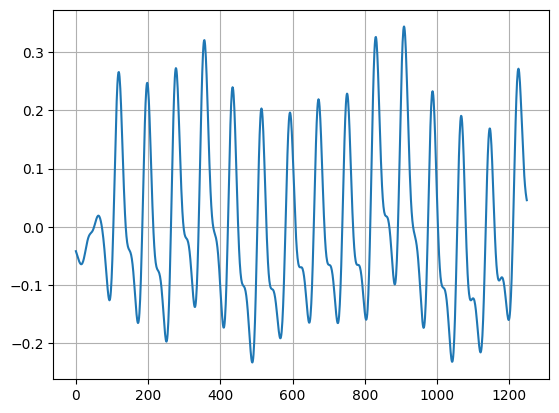

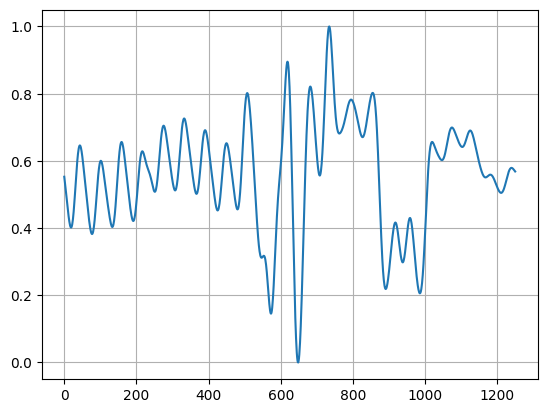

In [5]:
annotated_data = pd.read_csv(filtered_merged )
# annotated_data = pd.read_csv('5.New_annotated_data\patient_0_1_10.csv' )
labels = annotated_data.iloc[0] # this will exract the annotation 2nd row
raw_segments = (annotated_data.iloc[1 : , ])

assert not np.any(np.isnan(raw_segments)) , "INPUT DATA HAS NAN VALUES"

scaled_data = MyMinMaxScaler(raw_segments).values.T # mind the Transpose operation
# scaled_data = MyMinMaxScaler(raw_segments , [-1,1]).values.T # mind the Transpose operation
print(f"scaled_data shape = {scaled_data.shape}")

assert not np.any(np.isnan(scaled_data)) , "There are nan values in scaled Data"

plot_signal(range(len(raw_segments.iloc[ : ,0])) , raw_segments.iloc[ : ,0])

# split the dataset using test_train_split() function
x_train, x_test, y_train, y_test = train_test_split(scaled_data , labels, test_size = test_fraction, random_state = rand_state, stratify = labels)

plot_signal(range(len(x_train[5])) , x_train[5])

#print(f"scaled_data = \n{scaled_data}")
#print(f"x train shape : {x_train.shape}")
#print(f"x test shape : {x_test.shape}")

**Basic autoencoder**

#### Simplified Autoencoder

In [6]:
class Autoencoder(Model):
    def __init__(self, latent_dim, num_samples, activation_function, activation_function_latent_dim,  activation_function_decoder_out):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim

        # self.encoder = tf.keras.Sequential([
        #       layers.Flatten(),
        #       layers.Dense(800, activation=activation_function , name = "Encoder1" , kernel_initializer = 'RandomNormal'),
        #       layers.Dense(400, activation=activation_function , name = "Encoder2", kernel_initializer = 'RandomNormal'),
        #       layers.Dense(300, activation=activation_function , name = "Encoder3", kernel_initializer = 'RandomNormal'),
        #     ])
        # self.decoder = tf.keras.Sequential([
        #       layers.Dense(400, activation=activation_function , name = "Decoder1", kernel_initializer = 'RandomNormal'),
        #       layers.Dense(800, activation=activation_function , name = "Decoder2", kernel_initializer = 'RandomNormal'),
        #       layers.Dense(1250, activation=activation_function_decoder_out , name = "Decoder3", kernel_initializer = 'RandomNormal'),
        #     ])
        self.encoder = tf.keras.Sequential([
              layers.Flatten(),
              layers.Dense(latent_dim, activation=activation_function_latent_dim , name = "Encoder3", kernel_initializer = 'RandomNormal'),
            ])
        self.decoder = tf.keras.Sequential([
              layers.Dense(num_samples, activation=activation_function_decoder_out , name = "Decoder3", kernel_initializer = 'RandomNormal'),
            ])

    def call(self, input_data):
        encoded = self.encoder(input_data)
        decoded = self.decoder(encoded)
        return decoded

num_samples = x_test.shape[1]
print(f"num_samples per window = {num_samples}")

autoencoder = Autoencoder(latent_dim, num_samples, activation_func, activation_func_latent_dim , activation_func_dec_out)

autoencoder.compile(optimizer = optimizer, loss = losses.MeanSquaredError(), metrics = ['mae'])
# autoencoder.compile(optimizer = optimizer, loss = losses.MeanSquaredError(), metrics = ['mae'])
# autoencoder.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['mae'])

# tf.debugging.set_log_device_placement(True)
# configure early stopping
es = EarlyStopping(monitor='loss', patience=6)
tbCallBack = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)

autoencoder.fit(x_train, x_train,
                epochs = num_epochs,
                batch_size = batch_size,
                validation_data = (x_test, x_test),
                callbacks = [ tbCallBack])

num_samples per window = 1250


Epoch 1/300


449/449 [==============================] - 9s 11ms/step - loss: 0.0438 - mae: 0.1601 - val_loss: 0.0244 - val_mae: 0.1235
Epoch 2/300
449/449 [==============================] - 3s 8ms/step - loss: 0.0150 - mae: 0.0958 - val_loss: 0.0104 - val_mae: 0.0798
Epoch 3/300
449/449 [==============================] - 3s 7ms/step - loss: 0.0097 - mae: 0.0773 - val_loss: 0.0082 - val_mae: 0.0713
Epoch 4/300
449/449 [==============================] - 3s 7ms/step - loss: 0.0067 - mae: 0.0641 - val_loss: 0.0055 - val_mae: 0.0580
Epoch 5/300
449/449 [==============================] - 4s 8ms/step - loss: 0.0053 - mae: 0.0571 - val_loss: 0.0051 - val_mae: 0.0564
Epoch 6/300
449/449 [==============================] - 3s 7ms/step - loss: 0.0040 - mae: 0.0497 - val_loss: 0.0037 - val_mae: 0.0482
Epoch 7/300
449/449 [==============================] - 4s 10ms/step - loss: 0.0037 - mae: 0.0481 - val_loss: 0.0053 - val_mae: 0.0599
Epoch 8/300
449/449 [============

#### Save the model

In [7]:
autoencoder.encoder.summary()
autoencoder.decoder.summary()
# save model to file
autoencoder.encoder.save(encoder_save)
autoencoder.decoder.save(decoder_save)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 1250)              0         
                                                                 
 Encoder3 (Dense)            (None, 100)               125100    
                                                                 
Total params: 125100 (488.67 KB)
Trainable params: 125100 (488.67 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Decoder3 (Dense)            (None, 1250)              126250    
                                                                 
Total params: 126250 (493.16 KB)
Trainable params: 126250 (493.16 KB)
Non-trainable params: 0 (0.00 Byte)
____________________

#### Feature Extracted

<class 'numpy.ndarray'>
(3206, 1250)
3206
(3206, 100)
(100,)
1250
[[0.44092464]
 [0.48943967]
 [0.54222494]
 ...
 [0.32818675]
 [0.330338  ]
 [0.33221686]]


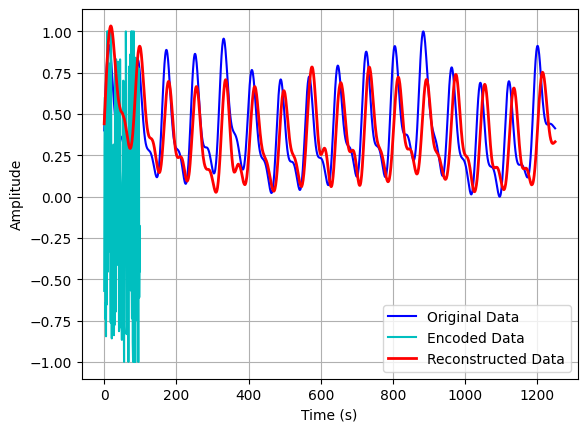

In [8]:
print(type(scaled_data))
print(scaled_data.shape)
print(len(scaled_data))
ae_features = autoencoder.encoder(scaled_data).numpy()
print(ae_features.shape)

segment = (ae_features)[90]
print(segment.shape)
reconstructed_seg = autoencoder.decoder(tf.reshape(segment , [-1,latent_dim])).numpy().reshape(num_samples,-1)
t = range(len(reconstructed_seg) )
print(len(reconstructed_seg))
print(reconstructed_seg)
plt.figure()
plt.plot(range(len(scaled_data[5]) ), scaled_data[5], 'b-', label='Original Data')
plt.plot(range(len(segment) ), segment, 'c-', label='Encoded Data')
plt.plot(range(len(reconstructed_seg) ), reconstructed_seg, 'r-', linewidth = 2, label='Reconstructed Data')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

##### Save extracted features

In [9]:
print(ae_features.shape)
ae_features_df = pd.DataFrame(data = ae_features , columns = [f"AE_{i}" for i in range(ae_features.shape[1])])
ae_features_df.to_csv(AE_features ,index=False)
# AE_features_df.to_csv(AE_features[:-4] + '_re_annotation.csv' ,index=False)

(3206, 100)


#### Check accuracy with RF

Note: you may need to restart the kernel to use updated packages.

~~~~~ RF:: WITH AE FEATURES ONLY ~~~~~


ic| 3721083458.py:82 in rf_model()- features.shape: (3206, 100)
ic| 3721083458.py:83 in rf_model()- labels.shape: (3206,)


Train instances : {0.0: 922, 1.0: 425, 2.0: 256}
Test instances : {1.0: 425, 0.0: 923, 2.0: 255}


[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:   24.1s


Accuracy(CV) : mean = 0.6226551075587545 :: std = 0.02211250716192881


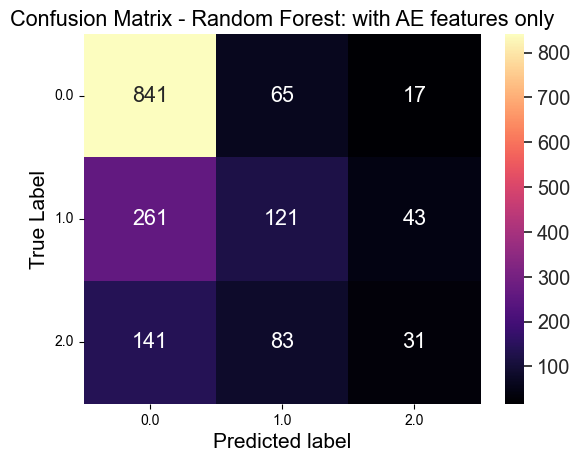

Confu mtrx = 
[[841  65  17]
 [261 121  43]
 [141  83  31]]

Classification Report:

              precision    recall  f1-score   support

         0.0       0.68      0.91      0.78       923
         1.0       0.45      0.28      0.35       425
         2.0       0.34      0.12      0.18       255

    accuracy                           0.62      1603
   macro avg       0.49      0.44      0.43      1603
weighted avg       0.56      0.62      0.57      1603


Avg score on test dataset = 0.619463505926388
RandomForestClassifier(criterion='entropy', n_estimators=15, random_state=54,
                       verbose=1)


In [10]:
rand_state = 54
test_fraction = 0.5
num_trees = 15
split_criteria = "entropy"

# for defuqqing
%pip install icecream --quiet
from icecream import ic
ic.configureOutput(includeContext=True)


# k of k fold cross validation
k = 9 # change if you want to experiment
#~~~~~~~~LIBRARIES~~~~~~~

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

# for cross validation
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score

# for creating confusion matrix
from sklearn import metrics

# to plot confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns # seaborn for additional functionality such as heat map

# additionals
from sklearn.metrics import classification_report

# to calculate number of instances of 0 and 1
from collections import Counter
# ~~~~~~~~~~~~END LIBRARIES~~~~~~~~~~~~~~~~~~~~~

def create_train_classifier(x_train_data , y_train_data):
    return RandomForestClassifier(n_estimators = num_trees , random_state = rand_state \
                                  , criterion = split_criteria, verbose = 1).fit(x_train_data , y_train_data)

def k_fold_s_crossval(x_train_data , y_train_data , k_value , classifier):
    rskf = RepeatedStratifiedKFold(n_splits = k_value , n_repeats = k_value , random_state = rand_state)
    result = cross_val_score(classifier , x_train_data , y_train_data , cv = rskf , verbose = 1)
    print("Accuracy(CV) : mean = {} :: std = {}".format(result.mean() , result.std()))


def test_n_results(x_test_data , y_test_data , classifier , description:str = ""):

    # Now TESTING the model and showing the results:
    # confusion matrix
    test_pred_decision_tree = classifier.predict(x_test_data)
    confusion_matrix = metrics.confusion_matrix(y_test_data , test_pred_decision_tree)
    class_list = np.unique(y_test_data)
    ax = plt.axes()
    sns.set_theme(font_scale=1.3)
    sns.heatmap(confusion_matrix , annot = True , fmt = "g" , ax = ax , cmap = "magma")
    ax.set_title('Confusion Matrix - Random Forest: ' + description)
    ax.set_xlabel("Predicted label" , fontsize = 15)
    ax.set_xticklabels(class_list)
    ax.set_ylabel("True Label", fontsize = 15)
    ax.set_yticklabels(class_list, rotation = 0)
    plt.show()

    # # roc curve plot
    # ax = plt.gca()
    # rfc_disp = metrics.RocCurveDisplay.from_estimator(classifier, x_test_data, y_test_data, ax=ax, alpha=0.8)
    # plt.show()

    # classification report
    print(f"Confu mtrx = \n{confusion_matrix}")
    print("\nClassification Report:\n")
    print(classification_report(y_test_data, test_pred_decision_tree))
    print("\nAvg score on test dataset = {}".format(classifier.score(x_test_data , y_test_data)))
    print(classifier)

def rf_model( local_features_file, annotated_file , description : str = ""):
    # get the dataset from the files
    features = pd.read_csv(local_features_file)
    labels = pd.read_csv(annotated_file).iloc[0] # this will exract the annotation 2nd row
    ic(features.shape)
    ic(labels.shape)
    if local_features_file == annotated_file:
        features.drop(index=0, inplace=True)
        features = features.T
    # elif local_features_file == ae_features_file:
    #     features = features.T
    if 'annotation' in features.columns :
        features.drop(['annotation'] , axis = 'columns' , inplace = True)

    assert not np.any(np.isnan(features)) , "ERROR::FEATURES DATAFRAME HAS NAN VALUES"
    # split the dataset using test_train_split() function
    x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size = test_fraction, random_state = rand_state, stratify = labels)

    num_instances_train = dict(Counter(y_train))
    num_instances_test = dict(Counter(y_test))
    print(f"Train instances : {num_instances_train}")
    print(f"Test instances : {num_instances_test}")

    clf = create_train_classifier(x_train , y_train)
    k_fold_s_crossval(x_train , y_train , k , clf)
    test_n_results(x_test , y_test , clf , description)

print("\n~~~~~ RF:: WITH AE FEATURES ONLY ~~~~~")
rf_model( AE_features, filtered_merged , description = "with AE features only")
# rf_model( ae_features_file, '5.New_annotated_data\patient_0_1_10.csv' , description = "with AE features only")